In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import tensorflow 
from sklearn import metrics

import tensorflow as tf
from keras.metrics import BinaryAccuracy, BinaryCrossentropy, Precision, Recall, Accuracy, AUC
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential

from keras.layers import  BatchNormalization, Dropout, Flatten, Dense, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications.efficientnet import EfficientNetB7
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.callbacks import Callback,ModelCheckpoint,ReduceLROnPlateau

import keras.backend as K

In [17]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [18]:
train_datagen = ImageDataGenerator(
        rescale = 1./255, 
        validation_split = 0.20,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(
        rescale = 1./255,
        validation_split = 0.20)

test_datagen  = ImageDataGenerator(
        rescale = 1./255)

In [19]:
train_dataset  = train_datagen.flow_from_directory(
    directory = '..\\Data\\Chest Cancer dataset\\train',
    target_size = (224,224),
    class_mode = 'categorical',
    batch_size = 32)

Found 613 images belonging to 4 classes.


In [20]:
validation_dataset = valid_datagen.flow_from_directory(
    directory = '..\\Data\\Chest Cancer dataset\\test',
    target_size = (224,224),
    class_mode = 'categorical',
    batch_size = 32)

Found 315 images belonging to 4 classes.


In [21]:
test_dataset = test_datagen.flow_from_directory(
    directory = '..\\Data\\Chest Cancer dataset\\valid',
    target_size = (224,224),
    class_mode = 'categorical',
    batch_size = 32)

Found 72 images belonging to 4 classes.


In [22]:
base_model = EfficientNetB7(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet")

In [23]:
for layer in base_model.layers[:-10]:
    layer.trainable=False

In [24]:
model=Sequential()

model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(4,activation='softmax'))

In [25]:
lr = ReduceLROnPlateau(monitor = 'val_loss',patience = 4,verbose = 1,factor = 0.5, min_lr = 0.001)
mcp = ModelCheckpoint('efcnt_model.h5')
es = EarlyStopping(verbose=1, patience=4)

In [26]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    return 2*(precision*recall)/(precision+recall+K.epsilon())

In [27]:
METRICS = [
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),  
      AUC(name='auc'),
      f1_score
]

In [28]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional)  (None, 7, 7, 2560)       64097687  
                                                                 
 dropout_2 (Dropout)         (None, 7, 7, 2560)        0         
                                                                 
 flatten_1 (Flatten)         (None, 125440)            0         
                                                                 
 batch_normalization_3 (Batc  (None, 125440)           501760    
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 32)                4014112   
                                                                 
 batch_normalization_4 (Batc  (None, 32)               128       
 hNormalization)                                      

In [30]:
efcnt_model = model.fit(train_dataset,validation_data = validation_dataset , epochs = 15, callbacks=[lr,mcp,es])

Epoch 1/15
20/20 [==============================] - 55s 2s/step - loss: 1.6017 - accuracy: 0.7100 - precision: 0.2851 - recall: 0.1060 - auc: 0.5212 - f1_score: 0.1451 - val_loss: 1.5039 - val_accuracy: 0.6905 - val_precision: 0.3810 - val_recall: 0.3810 - val_auc: 0.6163 - val_f1_score: 0.3796 - lr: 0.0010
Epoch 2/15
20/20 [==============================] - 31s 2s/step - loss: 1.4960 - accuracy: 0.7268 - precision: 0.2824 - recall: 0.0604 - auc: 0.5443 - f1_score: 0.1082 - val_loss: 1.3245 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6181 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 3/15
20/20 [==============================] - 31s 2s/step - loss: 1.4738 - accuracy: 0.7300 - precision: 0.2474 - recall: 0.0392 - auc: 0.5316 - f1_score: 0.0626 - val_loss: 1.3922 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5364 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 4/15
20/20 [==============================]

In [31]:
model_eval = model.evaluate(test_dataset)

3/3 [==============================] - 4s 2s/step - loss: 1.4234 - accuracy: 0.7500 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4375 - f1_score: 0.0000e+00


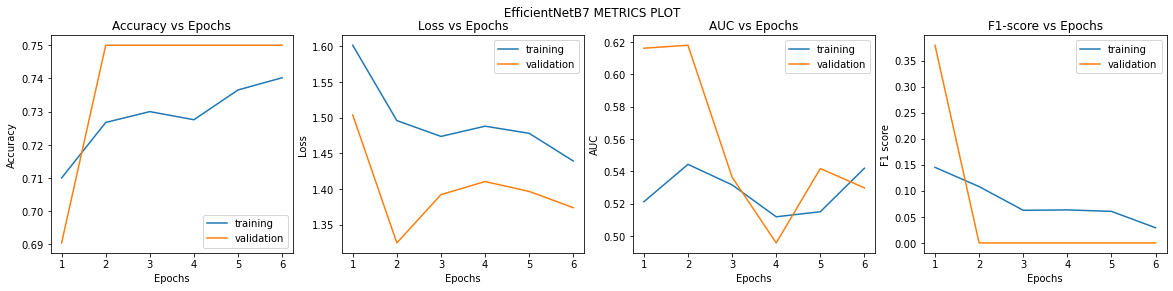

In [32]:
# PLOTTING RESULTS

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,f1,val_f1):
    
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize= (20,4))
    fig.suptitle(" EfficientNetB7 METRICS PLOT")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('Accuracy vs Epochs')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('Loss vs Epochs')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('AUC vs Epochs')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(f1) + 1), f1)
    ax4.plot(range(1, len(val_f1) + 1), val_f1)
    ax4.set_title('F1-score vs Epochs')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('F1 score')
    ax4.legend(['training', 'validation'])

    plt.show()

Train_Val_Plot(efcnt_model.history['accuracy'],efcnt_model.history['val_accuracy'],
               efcnt_model.history['loss'],efcnt_model.history['val_loss'],
               efcnt_model.history['auc'],efcnt_model.history['val_auc'],
               efcnt_model.history['f1_score'],efcnt_model.history['val_f1_score']
              )